In [1]:
from __future__ import division

import collections
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## NN libs
import keras
from keras import backend as K
from keras import regularizers
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import TensorBoard

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# local libs
import config, models, setup
import midi
from midi import generators as g
from utils import io, models_io, utils, plot
from capsule.layers import Capsule, Length
from capsule.capsulefunctions import squash, softmax, margin_loss

In [4]:
context = setup.init()

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_timestesp = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]

Setting up params

max min f 10.0 0.5
 >> Context(max_t=2.0, dt=0.05, n_timesteps=40, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
 sample length:  40.000000
 max_f: 10.000000, min_f: 0.500000


In [5]:
n = 500 * 1
dim4 = True
multiTrack = True
reduce_dims = midi.ReduceDimsOptions.MIDIFILE # GLOBAL
dn = 'drum_midi/'
x_train, labels = setup.import_data(context, n, dim4=dim4, reduce_dims=reduce_dims, dirname=dn, multiTrack=multiTrack, r=True)


Importing midi-data

Encoding midi-data
 500
> -> multi-track = True MidiFile
 [INFO] : 
 |  True


In [6]:
[(i,k) for i,k in enumerate(labels)]

[(0,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/01 8th Hat.mid"),
 (1,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/02 8th Ride.mid"),
 (2,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/03 16th Snare.mid"),
 (3,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/04 8th Ride.mid"),
 (4,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/05 16th Ride.mid"),
 (5,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/06 16th Ride.mid"),
 (6,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/07 16th Ride.mid"),
 (7,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM/01 8th Hat.mid"),
 (8,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM/02 8th Snare.mid"),
 (9,
  "../

In [7]:
x_train.shape

(500, 40, 9, 1)

In [8]:
m = int(x_train.shape[0] * 0.9)
x_train.shape, m

((500, 40, 9, 1), 450)

In [9]:
x_test = x_train[m:]
x_train = x_train[:m]

m (40, 9)


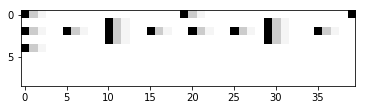

m (40, 9)


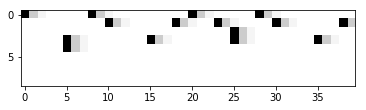

array(["../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/01 8th Hat.mid",
       '../datasets/drum_midi//50´s Drummer MIDI Files/06 Soul - Funk/08 Rim Soul 90BPM/01 4th Hat.mid'],
      dtype='<U106')

In [10]:
i = 0
j = 399
plot.single(x_train[i, :50,:,0])
plot.single(x_train[j, :50,:,0])
# plot.single(x_train[2, :50,:,0])
np.array(labels)[[i,j]]

In [11]:
input_shape = x_train[0].shape
timesteps = input_shape[0]
notes = input_shape[1]
input_shape

(40, 9, 1)

In [12]:
latent_dim = 2
intermediate_dim = 128
epsilon_std = 1.0

In [13]:
def encoder(input_shape, dropout=0.1):
    encoder_input = Input(shape=input_shape)
    nodes = np.prod(input_shape)
    timesteps, notes, channels = input_shape
    
    # Convolution
    h = encoder_input
    k = (2,1)
    s = (2,1)
    
    h = Conv2D(32, kernel_size=k, strides=1, activation='relu', padding='valid')(h)
    h = Conv2D(64, kernel_size=k, strides=s, activation='relu', padding='valid')(h)
    h = Conv2D(128, kernel_size=k, strides=s, activation='relu', padding='valid')(h)
    
    # input per note
    note_list = Permute([2,1,3], name='input_per_note')(h)
    
    rnn = SimpleRNN(128, name='rnn_per_note')
    reshape = Reshape((128,1))

    n_capsules = 10
    capsule_dim = 6
    n_routings=3
    share_weights=True
    capsule = Capsule(n_capsules, capsule_dim, n_routings, share_weights)

    x = Lambda(lambda layer: capsule(reshape(rnn(layer))) )
    h_per_note = TimeDistributed(x, name='TimeDistributed_per_note')(note_list)
    shape = K.int_shape(h_per_note)[1:]
    h_per_note = Reshape( [notes, np.prod(shape[1:3])] )(h_per_note)
    h_per_note = Flatten()(h_per_note)

    # 'global' input
    h = encoder_input
    h = Reshape(input_shape[:-1])(h)
    h = Conv1D(32, kernel_size=2, strides=1, activation='relu', padding='valid')(h)
    h = Conv1D(64, kernel_size=2, strides=2, activation='relu', padding='valid')(h)
    h = Conv1D(128, kernel_size=2, strides=1, activation='relu', padding='valid')(h)
    # old layers
#     h = Conv2D(1, kernel_size=k, strides=1, activation='relu', padding='valid')(h)
#     shape = K.int_shape(h)[1:]
#     h = Reshape(shape[0:2])(h) # (reduced_timesteps, notes)
#     h = Conv1D(32, kernel_size=2, strides=1, activation='relu', padding='valid')(h)
    h = SimpleRNN(128)(h)
#     h = LSTM(256)(h)
#     h = Bidirectional(LSTM(256)(h))
    h_global = h
    
    h = Reshape((-1,1))(h_global) # h_global h_per_note
#     h = Concatenate(axis=1)([h_global, h_per_note])

#     h = Reshape((-1,1))(h)
    
    n_capsules = 10
    capsule_dim = 6
    n_routings=3
    share_weights=True
    h = Capsule(n_capsules, capsule_dim, n_routings, share_weights)(h)   
    h = Flatten()(h)
    
    # Z Mean, Variance
    z_mean = Dense(latent_dim, name='z_mean')(h) # , activation='relu'
    z_log_var = Dense(latent_dim, name='z_log_var')(h) # , activation='relu'
        
    encoder_output = [z_mean, z_log_var]
    encoder_model = Model(encoder_input, encoder_output, name='encoder_model-')
    print('Extra params:', [k.count_params() for k in [rnn, reshape, capsule]])

    return encoder_model, encoder_input, z_mean, z_log_var

In [14]:
encoder_model, encoder_input, z_mean, z_log_var = encoder(input_shape)
encoder_model.summary()

shared weights, shape = (1, 1, 60) 60
shared weights, shape = (1, 1, 60) 60
Extra params: [32896, 0, 60]
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 40, 9, 1)     0                                            
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 40, 9)        0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 39, 32)       608         reshape_3[0][0]                  
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 19, 64)       4160        conv1d_1[0][0]                   
____

In [15]:
sample_ = lambda args: models.sample(args, z_mean, z_log_var, latent_dim, epsilon_std)

In [16]:
# z = Lambda(sampling)([z_mean, z_log_var])
z_input = encoder_model(encoder_input)
z_output = Lambda(sample_)(z_input)
# z_output = Lambda(sampl_, output_shape=(latent_dim,))(encoder_input)

In [17]:
def list_decoders(output_shape):
    # decoder_input = z_output
    # h = decoder_input
    # :output_shape = (timesteps, channels, channels) || (batches, filters, timesteps, channels)
    # keras offers just Conv2DTranspose and not Conv1DTranspose
    # - use 2D images during upsampling :: (timesteps, notes, channels) => (timesteps, notes, filters)
    # - use 1D images to optimize reconstruction :: (timesteps, filters) => (timesteps, notes)
    
    # image_data_format = 'channels_last'
    # goal shape: (timesteps, notes, channels)
    # start with the 'reverse': lots of small imgs => few large img
    
    timesteps, notes, channels = output_shape

    # keras.examples.variational_autoencoder_deconv.py
    decoders = []
    decoders += [ Dense(256) ]
    decoders += [ LeakyReLU(alpha=0.3) ]
    
    # add a bypass layer
    w = 256
    decoders += [ Dense(w, activation='relu') ]
    extra_decoders = []
    for _ in range(3):
        extra_decoders += [ Dense(w, activation='elu', bias_initializer='zeros') ]

    extra_d = Lambda(lambda layer: utils.composition(extra_decoders, layer))
    decoders += [ Lambda(lambda layer: Add()([layer, extra_d(layer)])) ]
    
    decoders += [ BatchNormalization(momentum=0.5) ]

    n = 4
    dim1, dim2, filters = n, int(timesteps/n), 250
    decoders += [ Reshape((n, int(w/n))) ]
    decoders += [ TimeDistributed(Dense(filters, activation='relu')) ]
    print(n*w/timesteps, timesteps, filters, n, timesteps*n*w/timesteps)
#     decoders += [ Reshape((timesteps, int(n*filters/timesteps) )) ]
#     decoders += [ Reshape((int(timesteps * filters*n/timesteps),)) ]
    decoders += [ Reshape((timesteps, int(filters*n/timesteps),)) ]
#     decoders += [ Reshape((40, 256)) ]

    decoders += [ TimeDistributed(Dense(notes, activation='sigmoid')) ]
    decoders += [ Reshape((timesteps, notes, 1)) ]

    return decoders

In [18]:
decoders = list_decoders(input_shape)

25.6 40 250 4 1024.0


In [19]:
decoded = utils.composition(decoders, z_output, verbose=False)
# layer1, = layers

In [20]:
# layer1.output

In [21]:
# instantiate VAE model
vae_input = encoder_input
vae_output = decoded
vae = Model(vae_input, vae_output)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 40, 9, 1)     0                                            
__________________________________________________________________________________________________
encoder_model- (Model)          [(None, 2), (None, 2 54480       input_1[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 2)            0           encoder_model-[1][0]             
                                                                 encoder_model-[1][1]             
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          768         lambda_3[0][0]                   
__________

In [22]:
# Compute VAE loss
def vae_loss(beta=1.):
#     beta = ((1.0 - tf.pow(hparams.beta_rate, tf.to_float(self.global_step)))
#             * hparams.max_beta)
#     self.loss = tf.reduce_mean(r_loss) + beta * tf.reduce_mean(kl_cost)
    # y_true, y_pred, z_mean, z_log_var, timesteps=150, notes=3, beta=1.
    xent_loss = timesteps * notes * keras.metrics.binary_crossentropy(K.flatten(vae_input), K.flatten(vae_output))
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    # kl_loss = max(kl_loss, free_bits)
    vae_loss = K.mean(xent_loss + beta * kl_loss)
    return vae_loss

vae_loss = vae_loss(beta=0.5)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
# vae.compile(optimizer=optimizer, loss=loss, metrics=metrics)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Output "reshape_7" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "reshape_7" during training.
  from ipykernel import kernelapp as app


In [23]:
K.int_shape(z_mean)

(None, 2)

In [24]:
batch_size = 10
epochs = 50
params = {'batch_size': batch_size, 'return_y': False}

In [25]:
phase_mod = 0.01
whitening = False

In [ ]:
m = 2
useDataGenerator = False
useDataGenerator = True

x = x_train
x1 = x_train[0] # 0
x2 = x_train[399] # 399
x_ = [x1,x2] # x_train[:m]
x = np.concatenate([x_ for _ in range(100)])
print('x:', x.shape)

print('batch_size =', batch_size)
if useDataGenerator:
    datagen = models.ImageDataGenerator(x_train, batch_size, phase_mod, whitening)
    history = collections.defaultdict(list)
    n_batches = datagen.__len__()
    for e in range(epochs):
        print('\n[Epoch %i/%i] >>>>>>>>>' % (e, epochs))
        for batch_i, (x_batch, y_batch) in enumerate(datagen.flow(x, x, batch_size)):
            print(' Batch %i/%i' % (batch_i,n_batches))
            x_ = x_batch
            # x_ = datagen.shuffle_3rd_dim(x_)
            x_ = datagen.shuffle_3rd_dim_soft(x_, rate=0.5, scale=0.1, verbose=0)
            h = vae.fit(x_, validation_data=(x_test, None), verbose=0)
            for k,v in h.history.items(): 
                print(' \\_%s' % k, [round(v_,) for v_ in v])
                history[k].append(v)
            if batch_i >= n_batches:
                break
else:
    h = vae.fit(x, epochs=epochs, validation_data=(x_test, None))
    history = h.history

x: (200, 40, 9, 1)
batch_size = 10

[Epoch 0/50] >>>>>>>>>
 Batch 0/45
 \_val_loss [267.0]
 \_loss [267.0]
 Batch 1/45
 \_val_loss [261.0]
 \_loss [262.0]
 Batch 2/45
 \_val_loss [258.0]
 \_loss [258.0]
 Batch 3/45
 \_val_loss [252.0]
 \_loss [254.0]
 Batch 4/45
 \_val_loss [249.0]
 \_loss [250.0]
 Batch 5/45
 \_val_loss [246.0]
 \_loss [248.0]
 Batch 6/45
 \_val_loss [244.0]
 \_loss [244.0]
 Batch 7/45
 \_val_loss [240.0]
 \_loss [242.0]
 Batch 8/45
 \_val_loss [239.0]
 \_loss [240.0]
 Batch 9/45
 \_val_loss [235.0]
 \_loss [236.0]
 Batch 10/45
 \_val_loss [234.0]
 \_loss [236.0]
 Batch 11/45
 \_val_loss [230.0]
 \_loss [231.0]
 Batch 12/45
 \_val_loss [228.0]
 \_loss [229.0]
 Batch 13/45
 \_val_loss [226.0]
 \_loss [227.0]
 Batch 14/45
 \_val_loss [224.0]
 \_loss [226.0]
 Batch 15/45
 \_val_loss [222.0]
 \_loss [222.0]
 Batch 16/45
 \_val_loss [216.0]
 \_loss [222.0]
 Batch 17/45
 \_val_loss [214.0]
 \_loss [222.0]
 Batch 18/45
 \_val_loss [210.0]
 \_loss [218.0]
 Batch 19/45
 \_val_

 \_val_loss [72.0]
 \_loss [50.0]
 Batch 35/45
 \_val_loss [70.0]
 \_loss [47.0]
 Batch 36/45
 \_val_loss [69.0]
 \_loss [49.0]
 Batch 37/45
 \_val_loss [70.0]
 \_loss [54.0]
 Batch 38/45
 \_val_loss [69.0]
 \_loss [48.0]
 Batch 39/45
 \_val_loss [71.0]
 \_loss [52.0]
 Batch 40/45
 \_val_loss [70.0]
 \_loss [48.0]
 Batch 41/45
 \_val_loss [70.0]
 \_loss [48.0]
 Batch 42/45
 \_val_loss [69.0]
 \_loss [48.0]
 Batch 43/45
 \_val_loss [72.0]
 \_loss [49.0]
 Batch 44/45
 \_val_loss [72.0]
 \_loss [47.0]
 Batch 45/45
 \_val_loss [76.0]
 \_loss [59.0]

[Epoch 4/50] >>>>>>>>>
 Batch 0/45
 \_val_loss [73.0]
 \_loss [53.0]
 Batch 1/45
 \_val_loss [71.0]
 \_loss [47.0]
 Batch 2/45
 \_val_loss [70.0]
 \_loss [45.0]
 Batch 3/45
 \_val_loss [73.0]
 \_loss [52.0]
 Batch 4/45
 \_val_loss [72.0]
 \_loss [52.0]
 Batch 5/45
 \_val_loss [72.0]
 \_loss [50.0]
 Batch 6/45
 \_val_loss [70.0]
 \_loss [45.0]
 Batch 7/45
 \_val_loss [69.0]
 \_loss [48.0]
 Batch 8/45
 \_val_loss [76.0]
 \_loss [60.0]
 Batch 9/45

 \_val_loss [80.0]
 \_loss [43.0]
 Batch 26/45
 \_val_loss [82.0]
 \_loss [42.0]
 Batch 27/45
 \_val_loss [79.0]
 \_loss [42.0]
 Batch 28/45
 \_val_loss [83.0]
 \_loss [39.0]
 Batch 29/45
 \_val_loss [77.0]
 \_loss [39.0]
 Batch 30/45
 \_val_loss [81.0]
 \_loss [42.0]
 Batch 31/45
 \_val_loss [76.0]
 \_loss [39.0]
 Batch 32/45
 \_val_loss [80.0]
 \_loss [42.0]
 Batch 33/45
 \_val_loss [78.0]
 \_loss [43.0]
 Batch 34/45
 \_val_loss [76.0]
 \_loss [38.0]
 Batch 35/45
 \_val_loss [76.0]
 \_loss [38.0]
 Batch 36/45
 \_val_loss [79.0]
 \_loss [41.0]
 Batch 37/45
 \_val_loss [80.0]
 \_loss [41.0]
 Batch 38/45
 \_val_loss [78.0]
 \_loss [39.0]
 Batch 39/45
 \_val_loss [75.0]
 \_loss [41.0]
 Batch 40/45
 \_val_loss [76.0]
 \_loss [41.0]
 Batch 41/45
 \_val_loss [81.0]
 \_loss [41.0]
 Batch 42/45
 \_val_loss [78.0]
 \_loss [39.0]
 Batch 43/45
 \_val_loss [77.0]
 \_loss [40.0]
 Batch 44/45
 \_val_loss [81.0]
 \_loss [43.0]
 Batch 45/45
 \_val_loss [76.0]
 \_loss [41.0]

[Epoch 8/50] >>>>>>>>>
 B

 \_val_loss [85.0]
 \_loss [39.0]
 Batch 19/45
 \_val_loss [91.0]
 \_loss [43.0]
 Batch 20/45
 \_val_loss [84.0]
 \_loss [38.0]
 Batch 21/45
 \_val_loss [86.0]
 \_loss [42.0]
 Batch 22/45
 \_val_loss [83.0]
 \_loss [39.0]
 Batch 23/45
 \_val_loss [81.0]
 \_loss [39.0]
 Batch 24/45
 \_val_loss [80.0]
 \_loss [38.0]
 Batch 25/45
 \_val_loss [86.0]
 \_loss [42.0]
 Batch 26/45
 \_val_loss [92.0]
 \_loss [40.0]
 Batch 27/45
 \_val_loss [84.0]
 \_loss [38.0]
 Batch 28/45
 \_val_loss [85.0]
 \_loss [37.0]
 Batch 29/45
 \_val_loss [85.0]
 \_loss [39.0]
 Batch 30/45
 \_val_loss [90.0]
 \_loss [43.0]
 Batch 31/45
 \_val_loss [88.0]
 \_loss [38.0]
 Batch 32/45
 \_val_loss [82.0]
 \_loss [38.0]
 Batch 33/45
 \_val_loss [82.0]
 \_loss [40.0]
 Batch 34/45
 \_val_loss [82.0]
 \_loss [41.0]
 Batch 35/45
 \_val_loss [79.0]
 \_loss [39.0]
 Batch 36/45
 \_val_loss [80.0]
 \_loss [39.0]
 Batch 37/45
 \_val_loss [80.0]
 \_loss [37.0]
 Batch 38/45
 \_val_loss [81.0]
 \_loss [40.0]
 Batch 39/45
 \_val_loss [

 \_val_loss [83.0]
 \_loss [40.0]
 Batch 11/45
 \_val_loss [85.0]
 \_loss [37.0]
 Batch 12/45
 \_val_loss [84.0]
 \_loss [39.0]
 Batch 13/45
 \_val_loss [86.0]
 \_loss [38.0]
 Batch 14/45
 \_val_loss [85.0]
 \_loss [38.0]
 Batch 15/45
 \_val_loss [91.0]
 \_loss [40.0]
 Batch 16/45
 \_val_loss [87.0]
 \_loss [38.0]
 Batch 17/45
 \_val_loss [89.0]
 \_loss [39.0]
 Batch 18/45
 \_val_loss [87.0]
 \_loss [37.0]
 Batch 19/45
 \_val_loss [84.0]
 \_loss [41.0]
 Batch 20/45
 \_val_loss [85.0]
 \_loss [37.0]
 Batch 21/45
 \_val_loss [84.0]
 \_loss [36.0]
 Batch 22/45
 \_val_loss [84.0]
 \_loss [37.0]
 Batch 23/45
 \_val_loss [85.0]
 \_loss [38.0]
 Batch 24/45
 \_val_loss [85.0]
 \_loss [35.0]
 Batch 25/45
 \_val_loss [85.0]
 \_loss [39.0]
 Batch 26/45
 \_val_loss [90.0]
 \_loss [41.0]
 Batch 27/45
 \_val_loss [88.0]
 \_loss [38.0]
 Batch 28/45
 \_val_loss [86.0]
 \_loss [37.0]
 Batch 29/45
 \_val_loss [83.0]
 \_loss [41.0]
 Batch 30/45
 \_val_loss [88.0]
 \_loss [37.0]
 Batch 31/45
 \_val_loss [

 Batch 0/45
 \_val_loss [87.0]
 \_loss [27.0]
 Batch 1/45
 \_val_loss [94.0]
 \_loss [31.0]
 Batch 2/45
 \_val_loss [92.0]
 \_loss [26.0]
 Batch 3/45
 \_val_loss [93.0]
 \_loss [28.0]
 Batch 4/45
 \_val_loss [96.0]
 \_loss [29.0]
 Batch 5/45
 \_val_loss [91.0]
 \_loss [27.0]
 Batch 6/45
 \_val_loss [87.0]
 \_loss [26.0]
 Batch 7/45
 \_val_loss [87.0]
 \_loss [31.0]
 Batch 8/45
 \_val_loss [88.0]
 \_loss [25.0]
 Batch 9/45
 \_val_loss [92.0]
 \_loss [25.0]
 Batch 10/45
 \_val_loss [92.0]
 \_loss [34.0]
 Batch 11/45
 \_val_loss [90.0]
 \_loss [24.0]
 Batch 12/45
 \_val_loss [87.0]
 \_loss [25.0]
 Batch 13/45
 \_val_loss [83.0]
 \_loss [30.0]
 Batch 14/45
 \_val_loss [95.0]
 \_loss [31.0]
 Batch 15/45
 \_val_loss [94.0]
 \_loss [30.0]
 Batch 16/45
 \_val_loss [93.0]
 \_loss [30.0]
 Batch 17/45
 \_val_loss [93.0]
 \_loss [33.0]
 Batch 18/45
 \_val_loss [101.0]
 \_loss [33.0]
 Batch 19/45
 \_val_loss [93.0]
 \_loss [32.0]
 Batch 20/45
 \_val_loss [91.0]
 \_loss [25.0]
 Batch 21/45
 \_val_lo

 \_val_loss [99.0]
 \_loss [30.0]
 Batch 39/45
 \_val_loss [100.0]
 \_loss [26.0]
 Batch 40/45
 \_val_loss [103.0]
 \_loss [28.0]
 Batch 41/45
 \_val_loss [106.0]
 \_loss [25.0]
 Batch 42/45
 \_val_loss [105.0]
 \_loss [26.0]
 Batch 43/45
 \_val_loss [105.0]
 \_loss [23.0]
 Batch 44/45
 \_val_loss [105.0]
 \_loss [27.0]
 Batch 45/45
 \_val_loss [104.0]
 \_loss [26.0]

[Epoch 23/50] >>>>>>>>>
 Batch 0/45
 \_val_loss [101.0]
 \_loss [25.0]
 Batch 1/45
 \_val_loss [104.0]
 \_loss [27.0]
 Batch 2/45
 \_val_loss [107.0]
 \_loss [26.0]
 Batch 3/45
 \_val_loss [107.0]
 \_loss [25.0]
 Batch 4/45
 \_val_loss [106.0]
 \_loss [26.0]
 Batch 5/45
 \_val_loss [99.0]
 \_loss [28.0]
 Batch 6/45
 \_val_loss [105.0]
 \_loss [26.0]
 Batch 7/45
 \_val_loss [97.0]
 \_loss [25.0]
 Batch 8/45
 \_val_loss [100.0]
 \_loss [26.0]
 Batch 9/45
 \_val_loss [99.0]
 \_loss [25.0]
 Batch 10/45
 \_val_loss [101.0]
 \_loss [26.0]
 Batch 11/45
 \_val_loss [98.0]
 \_loss [24.0]
 Batch 12/45
 \_val_loss [107.0]
 \_loss [2

 \_val_loss [105.0]
 \_loss [27.0]
 Batch 27/45
 \_val_loss [103.0]
 \_loss [26.0]
 Batch 28/45
 \_val_loss [104.0]
 \_loss [27.0]
 Batch 29/45
 \_val_loss [106.0]
 \_loss [25.0]
 Batch 30/45
 \_val_loss [105.0]
 \_loss [23.0]
 Batch 31/45
 \_val_loss [104.0]
 \_loss [25.0]
 Batch 32/45
 \_val_loss [105.0]
 \_loss [25.0]
 Batch 33/45
 \_val_loss [108.0]
 \_loss [29.0]
 Batch 34/45
 \_val_loss [110.0]
 \_loss [23.0]
 Batch 35/45
 \_val_loss [111.0]
 \_loss [23.0]
 Batch 36/45
 \_val_loss [110.0]
 \_loss [28.0]
 Batch 37/45
 \_val_loss [112.0]
 \_loss [25.0]
 Batch 38/45
 \_val_loss [108.0]
 \_loss [33.0]
 Batch 39/45
 \_val_loss [108.0]
 \_loss [23.0]
 Batch 40/45
 \_val_loss [110.0]
 \_loss [26.0]
 Batch 41/45
 \_val_loss [103.0]
 \_loss [26.0]
 Batch 42/45
 \_val_loss [104.0]
 \_loss [23.0]
 Batch 43/45
 \_val_loss [102.0]
 \_loss [24.0]
 Batch 44/45
 \_val_loss [105.0]
 \_loss [24.0]
 Batch 45/45
 \_val_loss [104.0]
 \_loss [24.0]

[Epoch 27/50] >>>>>>>>>
 Batch 0/45
 \_val_loss [103

 \_val_loss [104.0]
 \_loss [28.0]
 Batch 17/45
 \_val_loss [106.0]
 \_loss [23.0]
 Batch 18/45
 \_val_loss [104.0]
 \_loss [25.0]
 Batch 19/45
 \_val_loss [105.0]
 \_loss [24.0]
 Batch 20/45
 \_val_loss [105.0]
 \_loss [25.0]
 Batch 21/45
 \_val_loss [102.0]
 \_loss [27.0]
 Batch 22/45
 \_val_loss [108.0]
 \_loss [23.0]
 Batch 23/45
 \_val_loss [106.0]
 \_loss [25.0]
 Batch 24/45
 \_val_loss [111.0]
 \_loss [28.0]
 Batch 25/45
 \_val_loss [105.0]
 \_loss [24.0]
 Batch 26/45
 \_val_loss [106.0]
 \_loss [24.0]
 Batch 27/45
 \_val_loss [112.0]
 \_loss [26.0]
 Batch 28/45
 \_val_loss [112.0]
 \_loss [25.0]
 Batch 29/45
 \_val_loss [111.0]
 \_loss [26.0]
 Batch 30/45
 \_val_loss [110.0]
 \_loss [23.0]
 Batch 31/45
 \_val_loss [107.0]
 \_loss [23.0]
 Batch 32/45
 \_val_loss [107.0]
 \_loss [22.0]
 Batch 33/45
 \_val_loss [107.0]
 \_loss [22.0]
 Batch 34/45
 \_val_loss [106.0]
 \_loss [27.0]
 Batch 35/45
 \_val_loss [107.0]
 \_loss [24.0]
 Batch 36/45
 \_val_loss [107.0]
 \_loss [27.0]
 Batc

 \_val_loss [111.0]
 \_loss [24.0]
 Batch 3/45
 \_val_loss [109.0]
 \_loss [24.0]
 Batch 4/45
 \_val_loss [110.0]
 \_loss [24.0]
 Batch 5/45
 \_val_loss [116.0]
 \_loss [26.0]
 Batch 6/45
 \_val_loss [112.0]
 \_loss [25.0]
 Batch 7/45
 \_val_loss [113.0]
 \_loss [23.0]
 Batch 8/45
 \_val_loss [114.0]
 \_loss [23.0]
 Batch 9/45
 \_val_loss [114.0]
 \_loss [23.0]
 Batch 10/45
 \_val_loss [115.0]
 \_loss [27.0]
 Batch 11/45
 \_val_loss [116.0]
 \_loss [25.0]
 Batch 12/45
 \_val_loss [114.0]
 \_loss [27.0]
 Batch 13/45
 \_val_loss [109.0]
 \_loss [24.0]
 Batch 14/45
 \_val_loss [113.0]
 \_loss [25.0]
 Batch 15/45
 \_val_loss [115.0]
 \_loss [25.0]
 Batch 16/45
 \_val_loss [114.0]
 \_loss [26.0]
 Batch 17/45
 \_val_loss [111.0]
 \_loss [23.0]
 Batch 18/45
 \_val_loss [112.0]
 \_loss [25.0]
 Batch 19/45
 \_val_loss [114.0]
 \_loss [24.0]
 Batch 20/45
 \_val_loss [118.0]
 \_loss [27.0]
 Batch 21/45
 \_val_loss [113.0]
 \_loss [23.0]
 Batch 22/45
 \_val_loss [115.0]
 \_loss [26.0]
 Batch 23/45

 \_val_loss [110.0]
 \_loss [28.0]
 Batch 37/45
 \_val_loss [109.0]
 \_loss [26.0]
 Batch 38/45
 \_val_loss [111.0]
 \_loss [23.0]
 Batch 39/45
 \_val_loss [112.0]
 \_loss [24.0]
 Batch 40/45
 \_val_loss [109.0]
 \_loss [24.0]
 Batch 41/45
 \_val_loss [111.0]
 \_loss [26.0]
 Batch 42/45
 \_val_loss [111.0]
 \_loss [27.0]
 Batch 43/45
 \_val_loss [111.0]
 \_loss [27.0]
 Batch 44/45
 \_val_loss [112.0]
 \_loss [25.0]
 Batch 45/45
 \_val_loss [128.0]
 \_loss [27.0]

[Epoch 38/50] >>>>>>>>>
 Batch 0/45
 \_val_loss [118.0]
 \_loss [24.0]
 Batch 1/45
 \_val_loss [113.0]
 \_loss [26.0]
 Batch 2/45
 \_val_loss [111.0]
 \_loss [24.0]
 Batch 3/45
 \_val_loss [112.0]
 \_loss [27.0]
 Batch 4/45
 \_val_loss [109.0]
 \_loss [25.0]
 Batch 5/45
 \_val_loss [112.0]
 \_loss [25.0]
 Batch 6/45
 \_val_loss [109.0]
 \_loss [22.0]
 Batch 7/45
 \_val_loss [113.0]
 \_loss [23.0]
 Batch 8/45
 \_val_loss [111.0]
 \_loss [26.0]
 Batch 9/45
 \_val_loss [114.0]
 \_loss [23.0]
 Batch 10/45
 \_val_loss [114.0]
 \_lo

 Batch 25/45
 \_val_loss [118.0]
 \_loss [23.0]
 Batch 26/45
 \_val_loss [115.0]
 \_loss [25.0]
 Batch 27/45
 \_val_loss [115.0]
 \_loss [24.0]
 Batch 28/45
 \_val_loss [114.0]
 \_loss [28.0]
 Batch 29/45
 \_val_loss [114.0]
 \_loss [24.0]
 Batch 30/45
 \_val_loss [124.0]
 \_loss [25.0]
 Batch 31/45
 \_val_loss [116.0]
 \_loss [24.0]
 Batch 32/45
 \_val_loss [118.0]
 \_loss [26.0]
 Batch 33/45
 \_val_loss [118.0]
 \_loss [26.0]
 Batch 34/45
 \_val_loss [122.0]
 \_loss [26.0]
 Batch 35/45
 \_val_loss [125.0]
 \_loss [23.0]
 Batch 36/45
 \_val_loss [120.0]
 \_loss [26.0]
 Batch 37/45
 \_val_loss [115.0]
 \_loss [25.0]
 Batch 38/45
 \_val_loss [115.0]
 \_loss [24.0]
 Batch 39/45
 \_val_loss [123.0]
 \_loss [24.0]
 Batch 40/45
 \_val_loss [119.0]
 \_loss [26.0]
 Batch 41/45
 \_val_loss [119.0]
 \_loss [23.0]
 Batch 42/45
 \_val_loss [116.0]
 \_loss [22.0]
 Batch 43/45
 \_val_loss [120.0]
 \_loss [25.0]
 Batch 44/45
 \_val_loss [123.0]
 \_loss [22.0]
 Batch 45/45
 \_val_loss [119.0]
 \_loss

 \_val_loss [121.0]
 \_loss [26.0]
 Batch 13/45
 \_val_loss [122.0]
 \_loss [25.0]
 Batch 14/45
 \_val_loss [119.0]
 \_loss [23.0]
 Batch 15/45
 \_val_loss [122.0]
 \_loss [26.0]
 Batch 16/45
 \_val_loss [124.0]
 \_loss [24.0]
 Batch 17/45
 \_val_loss [118.0]
 \_loss [26.0]
 Batch 18/45
 \_val_loss [120.0]
 \_loss [26.0]
 Batch 19/45
 \_val_loss [123.0]
 \_loss [22.0]
 Batch 20/45
 \_val_loss [117.0]
 \_loss [21.0]
 Batch 21/45
 \_val_loss [121.0]
 \_loss [27.0]
 Batch 22/45
 \_val_loss [124.0]
 \_loss [24.0]
 Batch 23/45
 \_val_loss [124.0]
 \_loss [23.0]
 Batch 24/45
 \_val_loss [122.0]
 \_loss [26.0]
 Batch 25/45
 \_val_loss [116.0]
 \_loss [23.0]
 Batch 26/45
 \_val_loss [122.0]
 \_loss [24.0]
 Batch 27/45
 \_val_loss [122.0]
 \_loss [24.0]
 Batch 28/45
 \_val_loss [119.0]
 \_loss [24.0]
 Batch 29/45
 \_val_loss [120.0]
 \_loss [25.0]
 Batch 30/45
 \_val_loss [120.0]
 \_loss [26.0]
 Batch 31/45
 \_val_loss [121.0]
 \_loss [25.0]
 Batch 32/45
 \_val_loss [122.0]
 \_loss [26.0]
 Batc

 \_val_loss [116.0]
 \_loss [25.0]
 Batch 1/45
 \_val_loss [115.0]
 \_loss [22.0]
 Batch 2/45
 \_val_loss [117.0]
 \_loss [25.0]
 Batch 3/45
 \_val_loss [115.0]
 \_loss [25.0]
 Batch 4/45
 \_val_loss [120.0]
 \_loss [26.0]
 Batch 5/45
 \_val_loss [118.0]
 \_loss [23.0]
 Batch 6/45
 \_val_loss [117.0]
 \_loss [21.0]
 Batch 7/45
 \_val_loss [118.0]
 \_loss [25.0]
 Batch 8/45
 \_val_loss [117.0]
 \_loss [26.0]
 Batch 9/45
 \_val_loss [118.0]
 \_loss [27.0]
 Batch 10/45
 \_val_loss [118.0]
 \_loss [26.0]
 Batch 11/45
 \_val_loss [116.0]
 \_loss [26.0]
 Batch 12/45
 \_val_loss [116.0]
 \_loss [25.0]
 Batch 13/45
 \_val_loss [119.0]
 \_loss [27.0]
 Batch 14/45
 \_val_loss [117.0]
 \_loss [22.0]
 Batch 15/45
 \_val_loss [114.0]
 \_loss [25.0]
 Batch 16/45
 \_val_loss [112.0]
 \_loss [24.0]
 Batch 17/45
 \_val_loss [119.0]
 \_loss [23.0]
 Batch 18/45
 \_val_loss [118.0]
 \_loss [23.0]
 Batch 19/45


In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])

In [ ]:
x = x_train
x1 = x_train[0] # 0
x2 = x_train[399] # 399
x_ = [x1,x2] # x_train[:m]
x = np.concatenate([x_ for _ in range(100)])

In [ ]:
x.shape

In [ ]:
x_[0].shape

In [ ]:
i = 0
j = 1
k = 3
y = vae.predict(x[:10])
plot.single(x[0, :50, :, 0])
plot.single(y[i, :50, :, 0])
plot.single(x[1, :50, :, 0])
plot.single(y[j, :50, :, 0])

In [ ]:
x = datagen.shuffle_3rd_dim_soft(x_train[:10], rate=1, intensity=2, scale=1, verbose=1)
i = 0
plot.single(x_train[i,:,:,0])
plot.single(x[i,:,:,0])
x_ = vae.predict(x)
plot.single(x_[i,:,:,0])

In [ ]:
x.shape

In [ ]:
# min: these pixels are 'always' active
m = x.min(axis=0)
plot.multi(m[:30,:,0])

In [ ]:
# mean
m = x.mean(axis=0)
plot.single(m[:30,:,0])

## Encoder + Generator
A model to project inputs on the latent space

In [ ]:
# build a model to project inputs on the latent space
encoder = Model(encoder_input, z_mean)

In [ ]:
x_test.shape

In [ ]:
m = 100
x_train_encoded = encoder.predict(x_train[:m], batch_size=batch_size)
x_train_encoded.shape

In [ ]:
# y_test = range(x_train_encoded.shape[0])
y_test = np.concatenate([list(range(n)) for _ in range(int(m/n)+1)])[:m] / n
plt.figure(figsize=(6, 6))
plt.scatter(x_train_encoded[:, 0], x_train_encoded[:, 1], alpha=0.5, s=30) # c=y_test, 

In [ ]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], alpha=0.5, s=30) # , c=y_test
# plt.colorbar()

In [ ]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_decoded = utils.composition(decoders, decoder_input, verbose=False)
generator = Model(decoder_input, _decoded)

In [ ]:
# x_decoded[0].reshape(150,3)

In [ ]:
x_train.shape

In [ ]:
min_y = 0.01
max_y = 0.5
plot.latent(generator, batch_size, latent_dim,
       n=8,
       m=3,
       crop_size=30,
       margin_top=1,
       margin_left=1,
       min_x=0.05,
       max_x=0.95,
       min_y=min_y,
       max_y=max_y)

In [ ]:
min_y2 = max_y
plot.latent(generator, batch_size, latent_dim,
       n=6,
       m=2,
       crop_size=30,
       margin_top=1,
       margin_left=1,
       min_x=0.05,
       max_x=0.95,
       min_y=min_y2,
       max_y=0.95)